In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [68]:
#training set file
df = pd.read_csv('/Users/e5pianos/Desktop/2020 SPRING/COMP4641/project/lt_hydrator/training_licensedTreatment_combined_csv.csv',dtype=str,encoding='unicode_escape')
df = df[pd.notnull(df['label'])]
df = df[pd.notnull(df['text'])]
#testing set file (prediction)
dft = pd.read_csv('/Users/e5pianos/Desktop/2020 SPRING/COMP4641/project/lt_hydrator/testing_licensedTreatment_combined_csv.csv',dtype=str,encoding='unicode_escape')
dft = dft[pd.notnull(dft['text'])]
dft = dft[pd.notnull(dft['label'])]

#input of the model will be text + quoted_text
df['full_text']=df['text'].fillna('') + ' ' + df['quoted_text'].fillna('')
dft['full_text']=dft['text'].fillna('') + ' ' + dft['quoted_text'].fillna('')

<Figure size 720x288 with 0 Axes>

2    24449
0    16499
3    13147
1     9042
Name: label, dtype: int64


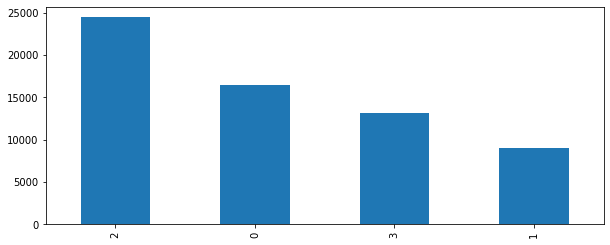

In [73]:
#statstic of classes

my_tags = ['0','1','2','3']
plt.figure(figsize=(10,4))
df.label.value_counts().plot(kind='bar');
print(df.label.value_counts())

In [69]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['full_text'] = df['full_text'].apply(clean_text)
dft['full_text'] = dft['full_text'].apply(clean_text)

In [70]:
df['full_text'].apply(lambda x: len(x.split(' '))).sum()
dft['full_text'].apply(lambda x: len(x.split(' '))).sum()

12462

1170884

In [71]:
X_train = df.full_text
y_train=df.label
X_test=dft.full_text
y_test=[]

In [72]:
####Naive Bayes classifier for multinomial models

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = nb.predict(X_test)

#perdicting
        
idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    #print(y_pred[idx])
    idx=idx+1


#CHANGE to your test files directory
#df=pd.read_csv("./lt_hydrator/t_testing_licensedTreatment_combined_csv.csv",dtype=str,encoding='unicode_escape')
dft['label']=yl
print(dft.label.value_counts())
dft.to_csv( "./lt_hydrator/t_testing_licensedTreatment_combined_csv.csv", index=False, encoding='utf-8-sig')



Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

2    24449
0    16499
3    13147
1     9042
Name: label, dtype: int64


In [ ]:
########Linear support vector machine

from sklearn.linear_model import SGDClassifier
import sklearn

sgd = sklearn.pipeline.Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

#perdicting
        
idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    idx=idx+1
    
#CHANGE to your test files directory
df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
df['label']=yl
df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')




In [ ]:
########Logistic regression

from sklearn.linear_model import LogisticRegression


logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

#predicting
idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    print(y_pred[idx])
    idx=idx+1
    
#CHANGE to your test files directory
df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
df['label']=yl
df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')


In [8]:
###Word2vec embedding and Logistic Regression

from gensim.models import Word2Vec
from gensim import models
import gensim

#CHANGE to your library directory
wv = gensim.models.KeyedVectors.load_word2vec_format("/Users/e5pianos/Desktop/2020 SPRING/COMP4641/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

unable to import 'smart_open.gcs', disabling that module


In [36]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))
import nltk
import logging
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean
def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

train=df
test=dft

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['full_text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['full_text']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)


['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



In [38]:

#predicting
idx=0
yl=[]
for i in X_test_word_average:
    yl.append(y_pred[idx])
    print(test.full_text[idx],y_pred[idx])
    idx=idx+1
   
#CHANGE to your test files directory
#df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
#df['label']=yl
#df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')


rt compoundboss elderly man died taking chloroquine phosphate additive used clean fish tanks fucking shit scummy man died taking drug president trump recently touted potential treatment coronavirus https tco mblv5hz2zg 0
fish tank cleaner dopes man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 0
actor daniel dae kim said took drug hydroxychloroquine treat coronavirus believes drug crucial successful recovery far https tco blumclhob0 1
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt cjtruth trump knowshe always knows us doctors claim trumps controversial hydroxychloroquine drug help 91 coronavir 0
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt dwuhlfelderlaw cnn start counter many dead taking advice trump man dies wife critical condition ingesting drug touted trump coronavirus treatment https tco exzd050mlj 1
rt n

rt kylegriffin1 lifesaving lupus drug short supply trump touted possible coronavirus treatment publicit 0
rt noahweiland scoop fda plans authorize emergency use experimental antiviral drug remdesivir coronavirus treatment 1
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
launches global solidarity trial four promising drugs effective treatmentsof coronavirus starting 8 countries https tco jj7tfm0ofn 1
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt kylegriffin1 lifesaving lupus drug short supply trump touted possible coronavirus treatment publicit 0
annkell23590297 billwylie3rd anchorbabynotes tribelaw number controlled studies failed demonstrate evidence hydroxychloroquin

rt kylegriffin1 lifesaving lupus drug short supply trump touted possible coronavirus treatment publicit 0
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
lifesaving lupus drug short supply trump touts possible coronavirus treatment https tco csiuadx43k via nbcnews 3
rt michaelcoudrey benshapiro trump showcases clinical trial hydroxychloroquine + azithromycin treatment effective coronav 1
gilead offer experimental ebola drug groups patients looking #coronavirus treatments rather handling requests casebycase basis medresjourno reports https tco 38r73e8whs 1
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt abc dr anthony fauci touts results trial examining experimental drug treatment novel coronavirus calling goo 1
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt michaelcoudrey benshapiro trump showcases clinical trial hyd

rt gtconway3d oh please cuomo isnt trying sell potential therapy like hes peddling trump steaks https tco l6lmk3gcbb governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer https tco yjyprtnhpk 0
rt gtconway3d oh please cuomo isnt trying sell potential therapy like hes peddling trump steaks https tco l6lmk3gcbb governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer https tco yjyprtnhpk 0
chip drug monitor americanswhy called emergency breaking fda plans authorize emergency use experimental antiviral drug remdesivir coronavirus treatment ny times 1
rt gtconway3d oh please cuomo isnt trying sell potential therapy like hes peddling trump steaks governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer https tco yjyprtnhpk 0
rt gtconway3d oh please cuomo isnt trying sell potential therapy like hes peddling trump steaks governor cuomo touting malaria drug potential treatment wuhan coronavirus media s

rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt tomfitton dr fauci presents yet another reason reopen america #constitutionovercoronavirus https tco bxqo9sv1kd dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven https tco 45davhzwls 2
rt tomfitton dr fauci presents yet another reason reopen america #constitutionovercoronavirus dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven https tco 45davhzwls 2
rt nycjim nigeria reports two cases chloroquine poisoning donald trump praised antimalaria drug treatment #coronav 2
rt tomfitton dr fauci presents yet another reason reopen america #constitutionovercoronavirus https tco bxqo9sv1kd dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven https tco 45davhzwls 2
savbehrmanndc c

dubes123 edselsalvana right contagion chriscuomo johnavlon briankarem jaketapper therickwilson https tco jp1snj1a2h sadder https tco u2gwou472v https tco t27h2atis1 https tco bgpe3ljgle scoop us drugmaker doubled price potential #coronavirus treatment chloroquine january outbreak sprea https tco gdzptca6qo 0
big news french researchers claim drug stops virus contagious 6 days 24 people administered still contagious 6 days #covid19outbreak #covid_19india #coronaviruspandemic #corona #coronavirus #treatment #choloroquine #french #france 0
rt tomfitton dr fauci presents yet another reason reopen america #constitutionovercoronavirus dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven https tco 45davhzwls 2
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor c

rt cbsnews dr fauci clinical trial potential coronavirus treatment drug remdesivir proven drug b 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt smart_md gilead says early results coronavirus drug trial show improvement shorter remdesivir treatment https tco vet13lvgx 1
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt cjtruth trump knowshe always knows us doctors claim trumps controversial hydroxychloroquine drug help 91 coronavir 0
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt msnbc dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven drug 3
rt nbcnews dr fauci speaks clinical

rt rhowardbrowne bahrain says drug touted trump coronavirus treatment working patients https tco 7gkzjextxz 1
demand drugs may treat #coronavirus increases people rely finding cant get refill recent data shows chloroquine orders spiked 3000 march hydroxychloroquine orders rose 260 drlapook joins us know drugs https tco ncul81lrqa 0
rt jsolomonreports breaking bahrain says drug touted trump possible treatment coronavirus working effectively patien 1
rt jsolomonreports breaking bahrain says drug touted trump possible treatment coronavirus working effectively patien 1
rt jsolomonreports breaking bahrain says drug touted trump possible treatment coronavirus working effectively patien 1
dug 6 leading repurposed drug efforts coronavirus treatments remdesivir hydroxychloroquine kevzara sarilumab actemra toxilizumab avigan favipiravir kaletra lopinavir ritonavir heres watch going forward https tco 04rngdgg14 2
rt jsolomonreports breaking bahrain says drug touted trump possible treatment corona

rt eyesonq us doctors claim trumps controversial hydroxychloroquine drug help 91 coronavirus patients argue 1
rt eyesonq us doctors claim trumps controversial hydroxychloroquine drug help 91 coronavirus patients argue 1
rt eyesonq us doctors claim trumps controversial hydroxychloroquine drug help 91 coronavirus patients argue 1
dow surges 350 points drug maker gilead says trial coronavirus treatment met initial goal https tco seoilcczoq https tco sdku4lfqss 0
rt cjtruth trump knowshe always knows us doctors claim trumps controversial hydroxychloroquine drug help 91 coronavir 0
rt eyesonq us doctors claim trumps controversial hydroxychloroquine drug help 91 coronavirus patients argue 1
us doctors claim trumps controversial hydroxychloroquine drug help 91 coronavirus patients argue wait controlled trials https tco jkryiv35mx youtube facebook cnni cnn msnbc_breaking 1
rt eyesonq us doctors claim trumps controversial hydroxychloroquine drug help 91 coronavirus patients argue 1
rt eyesonq u

rt breaking911 breaking dr fauci speaks potential coronavirus treatment drug remdesivir proven drug blo 3
rt msnbc dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven drug 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt msnbc dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven drug 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt msnbc dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven drug 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment

rt tomfitton false https tco pchgno09am man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt tomfitton false man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
false news liars wrong man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt tomfitton false man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt tomfitton false man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt tomfitton false man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt tomfitton false https tco pchgno09am man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt tomfitton false man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt

us drugmaker doubled price potential coronavirus treatment https tco 2ozbdh85os 3
rt johnny_joey headline wow https tco xwluvtoify man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
apparently trump came saying hydroxychloroquine possible treatment coronavirus cant get refill prescription need rheumatoid arthritis pharmacy back order 1
rt breaking911 breaking dr fauci speaks potential coronavirus treatment drug remdesivir proven drug blo 3
chrislhayes hi chris thank essential coronavirus coverage wondering could cover shortage plaquenil hydroxychloroquine antimalarial drug lupus patients like wife take regularly treat disease 1
rt sadietnresist man dies wife critical condition ingesting drug touted trump coronavirus treatment trum 2
rt cbsnews man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
potential coronavirus drug granted rare disease treatment status https tco afb6wgxdky #remdesivir

gilead said would longer seek orphandrug status coronavirus treatment bowing criticism outside groups said company profiteering pandemic https tco shjgbbwiku 0
rt colsdm lie repeated many liberal resister accounts man ate fish tank cleaner similar chemical man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
belgian #eu #parlement member frederiqueries wondering eu yet stocked hydroxychloroquine like #usa #india 4 treatment prophylactic prevention #rwanda #eac rwandahealth bycollinsmwai #covid19 #rwot 0
india bans export malaria drug trump touted coronavirus treatment 0
everything know remdesivir hydroxychloroquine 4 drugs tested coronavirus https tco le3eu2wvu3 businessinsider araclyla 0
norman says anything push future benefit preventing overtaxing hospital system hopefully getting better treatments vaccines online #kakenews #coronavirus #covid19 0
nice find #newenglandjournalofmedicine realdonaldtrump #disinfectant joshuapotash new engl

rt tomfitton false man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt tomfitton dr fauci presents yet another reason reopen america #constitutionovercoronavirus dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven https tco 45davhzwls 2
rt tomfitton dr fauci presents yet another reason reopen america #constitutionovercoronavirus dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven https tco 45davhzwls 2
rt tomfitton false man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt tomfitton false man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt tomfitton false man dies taking drug touted coronavirus treatment trump https tco vkvdxinn9f https tco yiofndi5pz 2
rt michaelmalice substances toxic corporate journalism man dies taking drug touted coronavirus treatment trump https t

rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt jsolomonreports israeli drugmaker donate 6 million doses promising coronavirus drug hydroxychloroquine https tco wr1qccakr8 3
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt pamelageller israeli drugmaker donate 6 million doses promising coronavirus drug hydroxychloroquine gd bless israel https 2
rt jsolomonreports israeli drugmaker donate 6 million doses promising coronavirus drug hydroxychloroquine https tco wr1qccakr8

price gouging laws need apply pharmaceuticals penalties must severe scoop us drugmaker doubled price potential #coronavirus treatment chloroquine january outbreak sprea https tco gdzptca6qo 3
turkeys ministry health says relatively low death toll thanks treatment protocols country controversial antimalaria drug #chloroquine hydroxychloroquinehttps tco 0jy4no7sb2 via cbsnews 3
rt therickwilson oh boy scoop us drugmaker doubled price potential #coronavirus treatment chloroquine january outbreak sprea https tco gdzptca6qo 1
rt therickwilson oh boy scoop us drugmaker doubled price potential #coronavirus treatment chloroquine january outbreak sprea https tco gdzptca6qo 1
rt therickwilson oh boy scoop us drugmaker doubled price potential #coronavirus treatment chloroquine january outbreak sprea https tco gdzptca6qo 1
rt therickwilson oh boy https tco ylp9h2bt8w scoop us drugmaker doubled price potential #coronavirus treatment chloroquine january outbreak sprea https tco gdzptca6qo 1
vladimir

rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
ajgaza lsarsour israels teva pharmaceuticals donate 6 million tablets malaria drug touted us government potential treatment coronavirus help us hospitals meet potential surge demand https tco 63p6hlid2r 0
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt barrymccolgan us drugmaker doubled price potential coronavirus treatment meanwhile cuba could make millions 3
rt jsolomonreports israeli drugmaker donate 6 million doses promising coronavirus drug hydroxychloroquine https tco wr1qccakr8 3
rt justthenews israeli drugmaker donate 6 million doses promising coronavirus drug hydroxychloroquine #jtnreports https tco 3
corona nursing warrior son covid19 got discharged treatment aiims aiims nurses union salute warriors ani nsgunionaiims

rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt jsolomonreports israeli drugmaker donate 6 million doses promising coronavirus drug hydroxychloroquine https tco wr1qccakr8 3
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt nxthompson today #coronavirus news twitter prescribed chloroquine malaria drug treatment covid19 wasnt long bef 1
rt jsolomonreports israeli drugmaker donate 6 million doses promising coronavirus drug hydroxychloroquine https tco wr1qccakr8 3
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt jsol

one would think trump would tire lying american people hydroxychloroquine donald trump says malaria drug coronavirus approved fda https tco d6kka9fthf 0
rt jsolomonreports magic pandemic pill trump confirms malaria drug appears working coronavirus treatment could tremendo 1
rt girlsreallyrule press conference thurs trump said malaria drug chloroquine approved use coronavirus treatment 1
rt complex fda begin testing drug used cure malaria possible treatment #coronavirus details https tco jw 3
rt jsolomonreports breaking potus confirms earlier reporting news trump praises malaria drug coronavirus treatment 1
rt jsolomonreports breaking potus confirms earlier reporting news trump praises malaria drug coronavirus treatment 1
rt girlsreallyrule press conference thurs trump said malaria drug chloroquine approved use coronavirus treatment 1
rt jsolomonreports breaking potus confirms earlier reporting news trump praises malaria drug coronavirus treatment 1
rt girlsreallyrule press conference t

time good old fashioned requisitioning war scenario thats scoop us drugmaker doubled price potential #coronavirus treatment chloroquine january outbreak sprea https tco gdzptca6qo 0
rt ahmed us drugmaker doubled price potential coronavirus treatment https tco ieodbo0cic 1
https tco omfgydoeiw scoop us drugmaker doubled price potential #coronavirus treatment chloroquine january outbreak sprea https tco gdzptca6qo 1
rt jeffreyluscombe lets put bigsurprised face #covid19 scoop us drugmaker doubled price potential #coronavirus treatment chloroquine january outbreak sprea https tco gdzptca6qo 1
rt davedufournba soon saw increase demand potential going utilised way folks scoop us drugmaker doubled price potential #coronavirus treatment chloroquine january outbreak sprea https tco gdzptca6qo 0
us drugmaker doubled price potential coronavirus treatment https tco v86wksrxed 3
rt lukewsavage nationalize immediately https tco w3mowyelfq scoop us drugmaker doubled price potential #coronavirus trea

rt msnbc dr leana wen says cautiously optimistic potential coronavirus treatment drug remdesivir https tco r2q 1
ih8evrybdy simonharristd vaccine could seven years away maybe never difficult get reliable antidote coronaviruses likes one previous ones would well gone 2027 anyway treatment would desirable save lives #covid19 0
fda issues emergency authorization use remdesivir covid19 treatment drug given coronavirus patients hospitalized severe disease https tco g4lecgoc7g 1
rt cgtnofficial us fda allowed emergency use drug #remdesivir treat #covid19 see means #coronavir 0
rt cgtnofficial us fda allowed emergency use drug #remdesivir treat #covid19 see means #coronavir 0
trump inaccurately claims malaria drug approved coronavirus treatment prompting fda correction https tco nxhqfqsl0f 1
top storymy tweets vladimir zev zelenko fox news doctor faces scrutiny hydroxychloroquine coronavirus treatment washington post https tco 91xmr4gfto see https tco apsqcsomj0 0
rt thesun first british coro

top story vladimir zev zelenko fox news doctor faces scrutiny hydroxychloroquine coronavirus treatment washington post https tco pinfkpigiy see https tco hpmirl2ljh 0
faseb j rethinking role hydroxychloroquine treatment covid19 https tco z8scj2irnc h tetano #coronavirus 3
rt newsweek hydroxychloroquine donald trump says malaria drug coronavirus approved fda https tco pzdx8vmfqa 0
#trending vladimir zev zelenko fox news doctor faces scrutiny hydroxychloroquine coronavirus treatment washington post https tco 3zcg99tfkb see https tco 6aejp9jkly 0
top story vladimir zev zelenko fox news doctor faces scrutiny hydroxychloroquine coronavirus treatment washington post https tco 6oudgwzgmj see https tco wp1o8vsalm 0
qtrresearch need read 1 million rounds treatment ye2020 drug reduces death rates 3pp hospital stays 5 days simply going cut gilead produce several million rounds coronavirus treatment next year https tco 6f0ba2l8ad 0
northmantrader need read 1m treatments ye2020 drug barely works is

us authorizes ebola drug remdesivir coronavirus treatment https tco veop3udvwi 2
trump officially announced following treatments coronavirus far 1 hcq 2 bringing uv light inside body 3 injecting disinfectant 4 gileads antiviral drug remdesivir speculations harm good hope realdonaldtrump understand priorities 0
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
pib_india pibhindi remdesivir medicine used india well many positive results drug usa really beneficial covid19 treatment narendramodi pmoindia amitshah amitshahoffice 0
rt adomonline us approves antiviral drug remdesivir covid19 treatment https tco cueg5hrd9s https tco ifnepue0l0 0
rt bbcworld us food drug administration given emergency approval drug remdesivir used coronavirus treatment preside 1
rt impeach_45now fda shuts trumps claim treatment 4 corona virus said antimalarial drug chloroquine shown ver 1
rt wagepeace us drugmaker doubled price potential coronavirus treatment

rt barrymccolgan us drugmaker doubled price potential coronavirus treatment meanwhile cuba could make millions 3
gilead sciences reports positive drug results remdesivir coronavirus treatment https tco vdr8kfkbtg via usatoday 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt observerug usa announces #coronavirus treatment breakthrough recovery time 11 days given #remdesivir drug compared 1
rt biannagolodryga surreal dr fauc

rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
white house hold another presser unless main speaker dr fauci dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven https tco 45davhzwls 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
cure important first step azt hiv dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven https tco 45davhzwls 3
want product upload #woocommerce shopify #wordpress #store contact https tco soozeog73g #benshapiro #assassinscreedvalhalla #blueivy #megbey #linkinpark scientists us anno

rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronaviru

rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronavirus media skewer offering 1
rt katiepavlich governor cuomo touting malaria drug potential treatment wuhan coronaviru

rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt daidriannn club june w savage remix lord please disinfect nation please dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven https tco 45davhzwls 0
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt tomfitton dr fauci presents yet another reason reopen america #constitutionovercoronavirus dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven https tco 45davhzwls 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug ga

rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
us chem shares soar oil positive coronavirus drug results https tco gxmcsbpbze #icis #chemicals #crude #oil #coronavirus #covid19 0
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt jsolomonreports israeli drugmaker donate 6 million doses promising coronavirus drug hydroxychloroquine https tco wr1qccakr8 3
drug hydroxychloroquine great outcome treating coronavirus abc went day dr fauci giving realdonaldtrump reality check outcomes drug showing broken spotty clips conference plz educate 1
rt abc dr anthony fauci touts results t

rt cjtruth trump knowshe always knows us doctors claim trumps controversial hydroxychloroquine drug help 91 coronavir 0
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
#hydroxychloroquine #covid19 #danger april 29 va secretary defends hydroxychloroquine treatment veterans food drug admin warned doctors last week prescribing drug covid19 patients serious potentially lifethreatening side effects https tco jqwaqsymer 2
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt nbcnews

rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
pharmacies selling heartburn drug studied coronavirus treatment https tco enxl1ujnpt 0
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt nbcnews dr fauci speaks clinical trial potential coronavirus treatment drug remdesivir proven dru 3
rt jsolomonreports israeli drugmaker donate 6 million doses promising coronavirus drug hydroxychloroquine https tco wr1qccakr8 3
rt biannagolodryga surreal dr fauci literally laying hydroxychl

rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt ddonsmith007 israeli drugmaker donate 6 million doses promising coronavirus drug hydroxychloroquine geller report news pres 2
trump promoting unproven drug treatments insults nbc reporter coronavirus briefing https tco szobxykdxc via nbcnews 3
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
hydroxychloroquine plaquenil possible treatment covid19 contract might ask doctor immediately might help small n studies best avail right happen take daily early ra little side effects https tco yjxfw8nhbf 0
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
rt biannagolodryga surreal dr fauci literally laying hydroxychloroquine coronavirus wonder drug game 2
joshtpm time public health cri

give trump coronavirus cure tiger https tco lgsbbcalez president trump twice tested negative coronavirus said may take drug hydroxychloroquine https tco zlmc9shuzz 2
president trump twice tested negative coronavirus said may take drug hydroxychloroquine https tco zlmc9shuzz 2
people died result taking drug mentioned wrong dose mixed drugs torn sick moron giving useless advice slightly hoping goes ahead pops big pack keels makes world cleaner place president trump twice tested negative coronavirus said may take drug hydroxychloroquine https tco zlmc9shuzz 0
drs take preventative measures hes president president trump twice tested negative coronavirus said may take drug hydroxychloroquine https tco zlmc9shuzz 2
rt toryboy1960 utterly deranged https tco 5gqdvx45ew president trump twice tested negative coronavirus said may take drug hydroxychloroquine https tco zlmc9shuzz 2
mr president cnn realdonaldtrump potus https tco idmropnek5 president trump twice tested negative coronavirus said ma

KeyError: 25486

In [8]:
###BOW with keras

import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils



train_posts = df['full_text']
train_tags = df['label']

test_posts = dft['full_text']
test_tags = []


In [ ]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


In [ ]:
batch_size = 32
epochs = 20

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

In [ ]:
#predicting

text_labels = encoder.classes_ 


yl=[]

for i in x_test:
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    yl.append(predicted_label)
    #print("Predicted label: " + predicted_label + "\n")
    
    
#CHANGE to your test files directory
df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
df['label']=yl
df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')


In [9]:
##Doc2vec and Logistic Regression

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import gensim


def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

X_train, X_test, y_train, y_test = df.full_text,df_label,dft_full_text,dft_label
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

In [ ]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

In [ ]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [ ]:
#predicting
idx=0
yl=[]
for i in test_vectors_dbow:
    yl.append(y_pred[idx])
    print(y_pred[idx])
    idx=idx+1
    
#CHANGE to your test files directory
df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
df['label']=yl
df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')
